#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, GRU
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score 
from time import time
import os
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

#Downloading some packages

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Creating the model

Files 'spam.csv' and 'glove.6B.50d.txt' are uploaded to the path: '/content/'

In [ ]:
class CustomHyperParameters():
  MAX_SEQUENCE_LEN = 22 
  BATCH_SIZE = 32
  NUM_EPOCHS = 10
  LEARNING_RATE = 1e-4
  EMBEDDING_DIMENSIONS = 50 
  FILE_NAME = 'spam.csv'
  CSV_FILE_LOCATION = "/content/" + FILE_NAME
  MODEL_NAME = 'SpamModel.h5'
  H5_MODEL_LOCATION = "/content/" + MODEL_NAME


In [ ]:
class CustomDataLoader():

  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.df = self.loading_into_dataframe()

  def loading_into_dataframe(self):
    whole_data_into_dataframe = pd.read_csv(self.customHyperParameters.CSV_FILE_LOCATION, encoding = "ISO-8859-1")
    sliced_df = whole_data_into_dataframe.iloc[:,:2]
    sliced_df['v1']=sliced_df['v1'].replace({'ham':0,'spam':1})
    sliced_df.rename({'v1': 'spam_labels', 'v2': 'text_messages'}, axis=1, inplace=True)
    return sliced_df
    
if __name__ == '__main__':
  p = CustomDataLoader()
  print(p.df)

      spam_labels                                      text_messages
0               0  Go until jurong point, crazy.. Available only ...
1               0                      Ok lar... Joking wif u oni...
2               1  Free entry in 2 a wkly comp to win FA Cup fina...
3               0  U dun say so early hor... U c already then say...
4               0  Nah I don't think he goes to usf, he lives aro...
...           ...                                                ...
5567            1  This is the 2nd time we have tried 2 contact u...
5568            0              Will Ì_ b going to esplanade fr home?
5569            0  Pity, * was in mood for that. So...any other s...
5570            0  The guy did some bitching but I acted like i'd...
5571            0                         Rofl. Its true to its name

[5572 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
class CustomTokenizer():
  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.customDataLoader = CustomDataLoader()
    self.tokenizer_object = Tokenizer()

    self.corpus = self.create_corpus()
    self.fitting_the_Tokizer()

  def create_corpus(self):
    df = self.customDataLoader.df
    dataframe_as_list = pd.Series.tolist(df['text_messages'])
    corpus = []
    for el in dataframe_as_list:
      text = re.sub('[^a-zA-Z]', ' ', el)  
      text = text.lower() 
      text = [w for w in word_tokenize(text)]
      text = [w for w in text if not w in set(stopwords.words('english')) and w.isalpha()] 
      corpus.append(text)
    return corpus

  def fitting_the_Tokizer(self):
    self.tokenizer_object.fit_on_texts(self.corpus)

  def tokenize_and_pad(self, dataToBeTokenized):
    sequences=self.tokenizer_object.texts_to_sequences(dataToBeTokenized)
    tweet_pad=pad_sequences(sequences,maxlen=self.customHyperParameters.MAX_SEQUENCE_LEN,truncating='post',padding='post')
    return tweet_pad
  
  def get_the_number_of_words(self):
    word_index=CustomTokenizer().tokenizer_object.word_index
    num_words=len(word_index)+1
    return (word_index, num_words)

In [ ]:
class CustomEmbeddings():
  FILE_NAME = 'glove.6B.50d.txt'
  CSV_FILE_LOCATION = "/content/" + FILE_NAME

  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.tokenizer_obj = CustomTokenizer()

    self.dict_with_embeddings = self.creating_embedding_dict()
    
  def creating_embedding_dict(self):
    dict_with_embeddings={}
    with open(CustomEmbeddings.CSV_FILE_LOCATION,'r') as f:
      for line in f:
        values = line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        dict_with_embeddings[word]=vectors
    return dict_with_embeddings

  def creating_embedding_matrix(self):
    word_index, num_words=self.tokenizer_obj.get_the_number_of_words()
    embedding_matrix=np.zeros((num_words,self.customHyperParameters.EMBEDDING_DIMENSIONS))
    for word,i in tqdm(word_index.items()):
        emb_vec=self.dict_with_embeddings.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec
    return embedding_matrix

In [ ]:
class CustomDataSplitter():
  def __init__(self):
    self.customDataLoader = CustomDataLoader()
    self.customTokenizer = CustomTokenizer()
    self.padded_data = self.customTokenizer.tokenize_and_pad(self.customTokenizer.corpus)

    self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = self.splitting_the_data(self.padded_data, self.customDataLoader.df.spam_labels.values)

  def splitting_the_data(self, padded_text, labels):
    X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(padded_text,labels, test_size=.3, random_state=2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_and_test,y_val_and_test, test_size=.33, random_state=2)

    print('Shape of train sequences: ',X_train.shape)
    print("Shape of Validation sequences: ",X_val.shape)
    print("Shape of Test sequences: ",X_test.shape)
    print('Shape of train labels: ',y_train.shape)
    print("Shape of Validation  labels: ",y_val.shape)
    print("Shape of Test  labels: ",y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test 

In [ ]:
def finding_true_positives_as_percent(y_true, y_pred):
  y_pred = K.round(y_pred) 
  y_pred = tf.dtypes.cast(y_pred, tf.int32) 
  y_true = tf.dtypes.cast(y_true, tf.int32)
  indexes_of_true_values = tf.where(y_true == 1)
  selected_actual_value = tf.gather_nd( y_true, indexes_of_true_values,) 
  selected_predicted_value = tf.gather_nd(y_pred, indexes_of_true_values,) 
  comparing_the_2_values = tf.math.equal(selected_actual_value, selected_predicted_value)
  casted_values = tf.dtypes.cast(comparing_the_2_values, tf.float64) 
  true_positives_percent = tf.reduce_mean(casted_values)
  return true_positives_percent

def finding_true_negatives_as_percent(y_true, y_pred):
  y_pred = K.round(y_pred)
  y_pred = tf.dtypes.cast(y_pred, tf.int32)
  y_true = tf.dtypes.cast(y_true, tf.int32)
  indexes_of_true_values = tf.where(y_true != 1)
  selected_actual_value = tf.gather_nd( y_true, indexes_of_true_values,) 
  selected_predicted_value = tf.gather_nd(y_pred, indexes_of_true_values,) 
  comparing_the_2_values = tf.math.equal(selected_actual_value, selected_predicted_value)
  casted_values = tf.dtypes.cast(comparing_the_2_values, tf.float64)
  true_negatives_percent = tf.reduce_mean(casted_values)
  return true_negatives_percent

def finding_false_negatives_as_percent(y_true, y_pred):
  y_pred = K.round(y_pred)
  y_pred = tf.dtypes.cast(y_pred, tf.int32)
  y_true = tf.dtypes.cast(y_true, tf.int32)
  indexes_of_false_values = tf.where(y_true == 1)
  selected_actual_value = tf.gather_nd(y_true, indexes_of_false_values,) 
  selected_predicted_value = tf.gather_nd((1 - y_pred), indexes_of_false_values,) 
  comparing_the_2_values = tf.math.equal(selected_actual_value, selected_predicted_value)
  casted_values = tf.dtypes.cast(comparing_the_2_values, tf.float64)
  false_negatives_percent = tf.reduce_mean(casted_values)
  return false_negatives_percent

def finding_false_positives_as_percent(y_true, y_pred):
  y_pred = K.round(y_pred)
  y_pred = tf.dtypes.cast(y_pred, tf.int32)
  y_true = tf.dtypes.cast(y_true, tf.int32)
  indexes_of_false_values = tf.where(y_true != 1)
  selected_actual_value = tf.gather_nd(y_true, indexes_of_false_values,) 
  selected_predicted_value = tf.gather_nd((1 - y_pred), indexes_of_false_values,) 
  comparing_the_2_values = tf.math.equal(selected_actual_value, selected_predicted_value)
  casted_values = tf.dtypes.cast(comparing_the_2_values, tf.float64)
  false_positives_percent = tf.reduce_mean(casted_values)
  return false_positives_percent

def custom_f1_score(y_true, y_pred):
  true_positive = finding_true_positives_as_percent(y_true, y_pred)
  true_negative = finding_true_negatives_as_percent(y_true, y_pred)
  false_positive = finding_false_positives_as_percent(y_true, y_pred)
  false_negative = finding_false_negatives_as_percent(y_true, y_pred)

  precision = true_positive/ (true_positive + false_positive + K.epsilon())
  recall =  true_positive /(true_positive + false_negative + K.epsilon())

  custom_f1_score = 2 * (precision * recall)/(precision + recall + K.epsilon())
  f1 = tf.where(tf.math.is_nan(custom_f1_score), tf.zeros_like(custom_f1_score), custom_f1_score)
  return  tf.keras.backend.mean(f1)

def custom_f_0_point_8_score(y_true, y_pred):
  true_positive = finding_true_positives_as_percent(y_true, y_pred)
  true_negative = finding_true_negatives_as_percent(y_true, y_pred)
  false_positive = finding_false_positives_as_percent(y_true, y_pred)
  false_negative = finding_false_negatives_as_percent(y_true, y_pred)

  precision = true_positive/ (true_positive + false_positive + K.epsilon())
  recall =  true_positive /(true_positive + false_negative + K.epsilon())

  custom_f1_score = (1+0.8**2) * (precision * recall)/((precision* 0.8**2) + recall + K.epsilon()) 
  f1 = tf.where(tf.math.is_nan(custom_f1_score), tf.zeros_like(custom_f1_score), custom_f1_score)
  return  tf.keras.backend.mean(f1)


In [ ]:
class SpamModel():

  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.dataSplitter = CustomDataSplitter()
    self.embeddings = CustomEmbeddings()
    self.tokenizer_obj = CustomTokenizer()

    self.already_fine_tuned()

  def already_fine_tuned(self):
    if os.path.exists(self.customHyperParameters.H5_MODEL_LOCATION):
      self.loading_the_model()
    else:
      self.running_the_model()
      self.saving_the_model()

  def saving_the_model(self):
    self.model.save(filepath = self.customHyperParameters.H5_MODEL_LOCATION,  overwrite=True, include_optimizer=True)

  def loading_the_model(self):
    self.model = load_model(filepath = self.customHyperParameters.H5_MODEL_LOCATION, custom_objects= {'custom_f1_score': custom_f1_score, 'custom_f_0_point_8_score' : custom_f_0_point_8_score})
    self.model.summary()

  def running_the_model(self):
    _, num_words=self.tokenizer_obj.get_the_number_of_words()
    self.embedding_matrix = self.embeddings.creating_embedding_matrix()
    self.model = self.defining_model_architecture(num_words, self.customHyperParameters.MAX_SEQUENCE_LEN, self.embedding_matrix)
    self.defining_a_compiler()
    self.fitting_the_model(self.dataSplitter.X_train, self.dataSplitter.y_train, self.dataSplitter.X_val, self.dataSplitter.y_val,)
    self.evaluating_the_model(self.dataSplitter.X_test, self.dataSplitter.y_test)
    self.vizualizing_confusion_matrix(self.dataSplitter.X_test, self.dataSplitter.y_test)
    self.making_of_roc_curve(self.dataSplitter.X_test, self.dataSplitter.y_test)

  def defining_model_architecture(self, NUM_WORDS, MAX_LEN, embedding_matrix):
    model=Sequential()
    embedding_layer=Embedding(NUM_WORDS,self.customHyperParameters.EMBEDDING_DIMENSIONS,embeddings_initializer=Constant(embedding_matrix),
                      input_length=MAX_LEN,trainable=False)
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
    model.add(tf.keras.layers.GRU(32,return_sequences=True))
    model.add(tf.keras.layers.GRU(16))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

  def defining_a_compiler(self):
    optimzer=Adam(learning_rate=self.customHyperParameters.LEARNING_RATE)
    self.model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['acc', custom_f1_score, custom_f_0_point_8_score, tf.keras.metrics.AUC()])
    self.model.summary()

  def fitting_the_model(self, X_train, y_train, X_val, y_val):
    self.model.fit(X_train,y_train,batch_size=self.customHyperParameters.BATCH_SIZE,epochs=self.customHyperParameters.NUM_EPOCHS,validation_data=(X_val,y_val),verbose=1)

  def evaluating_the_model(self, X_test, y_test):
    eval_metric = self.model.evaluate(x =X_test , y = y_test, batch_size =self.customHyperParameters.BATCH_SIZE , verbose=1, )
    print(f'Performance of the Test set: {eval_metric}')

  def making_predictions(self, iterator_with_messages_to_be_predicted):
    prediction = self.model.predict(x = iterator_with_messages_to_be_predicted, verbose=0,)
    return prediction

  def vizualizing_confusion_matrix(self, y_to_be_predicted, y_true): 
    predictions = self.making_predictions(y_to_be_predicted)
    y_pred = predictions > 0.5
    data = confusion_matrix(y_true, y_pred)
    print(data)
    fig, ax = plot_confusion_matrix(conf_mat=data,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    cmap = 'cool',
                                    figsize = (10, 7))
    plt.show()

  def making_of_roc_curve(self,y_to_be_predicted, y_true): 
    predictions = self.making_predictions(y_to_be_predicted)
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_true, predictions)
    print('roc_auc_score for SpamModel: ', roc_auc_score(y_true, predictions)) 
    
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - SpamModel')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#RUNNING THE MODEL

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Shape of train sequences:  (3900, 22)
Shape of Validation sequences:  (1120, 22)
Shape of Test sequences:  (552, 22)
Shape of train labels:  (3900,)
Shape of Validation  labels:  (1120,)
Shape of Test  labels:  (552,)


100%|██████████| 7560/7560 [00:00<00:00, 535009.42it/s]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 22, 50)            378050    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 22, 50)            0         
_________________________________________________________________
gru_12 (GRU)                 (None, 22, 64)            22272     
_________________________________________________________________
gru_13 (GRU)                 (None, 22, 32)            9408      
_________________________________________________________________
gru_14 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

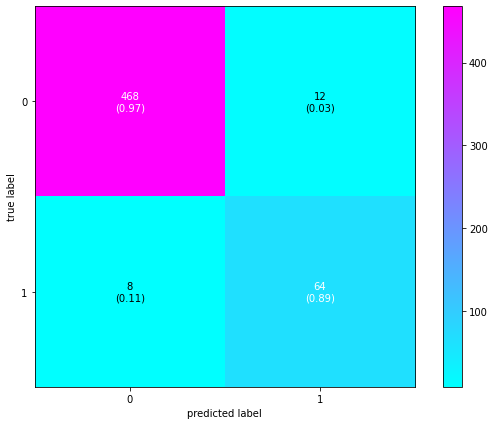

roc_auc_score for SpamModel:  0.9741898148148148


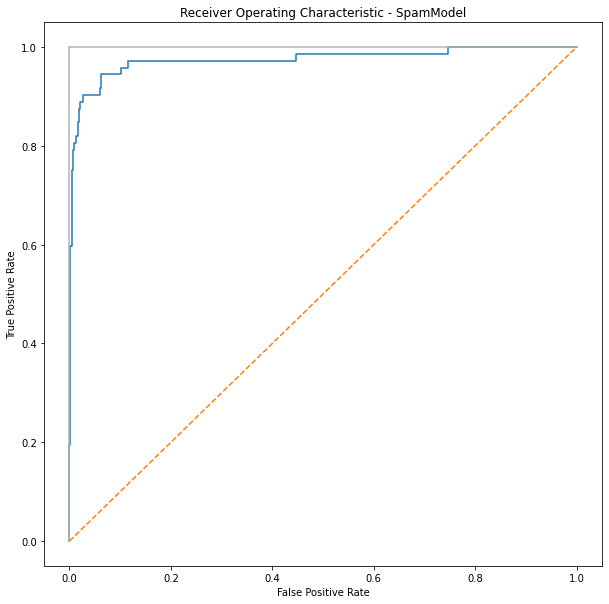

In [ ]:
spamModel = SpamModel() 

#How well our model makes predictions

Predictions on selfmade examples

In [ ]:
#Examples of Spam and non-Spam messages:
spam_messages_list = ['Hello. We detected fraudulent activity on your Apple iCloud account. To reset password www.applesupport/1234ds.com',
                      'You received 3 bitcoins($14,242 USD) in your account. Register to accept the transfer: https://bitcoinmine/232qq.com',
                      'DSK BANK: Your account is temporary locked. Please log in at https://dskbank/support/verification.bg to verify that its you.',
                      'Congratulations! You are the 1000 user registered to https://ifeelhappy.com and you win 10 000 $. Log in to https://ifeelhappy.com to claim your reward.']
spam_messages_labels = [1,1,1,1]
non_spam_messages_list = ["Hello Ivan, it's me - Nataly. Could you return me the books i borrowed you last week?",
                          'hi, nice to meet you, how are u? watcha you doin?',
                          "I am telling you Gerasim is a liar, believe me, dont trust him and go get your documents at 5 i'clock",
                          'Heheheh, that was a nice joke, i would remember it and keep on laughting at it for weeks, xaxaxaxaaxa :D:D:D::d']
non_spam_messages_labels = [0,0,0,0]
all_examples = spam_messages_list + non_spam_messages_list
all_examples_labels =  spam_messages_labels + non_spam_messages_labels

In [ ]:
#Predictions on both spam and nonspam
temp_tokenizer = CustomTokenizer()
padded_data = temp_tokenizer.tokenize_and_pad(all_examples)
spamModel.making_predictions(padded_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


array([[0.59490114],
       [0.6679729 ],
       [0.5144954 ],
       [0.8356271 ],
       [0.04656857],
       [0.00707495],
       [0.00844613],
       [0.00704524]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[[4 0]
 [0 4]]


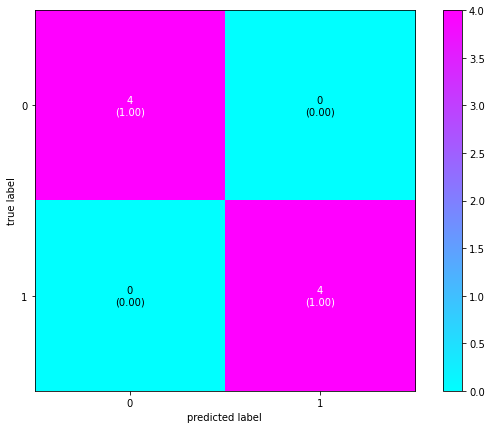

In [ ]:
#Confusion matrix on both spam and non_spam messages
temp_tokenizer = CustomTokenizer()
padded_data = temp_tokenizer.tokenize_and_pad(all_examples)
spamModel.vizualizing_confusion_matrix(padded_data, np.array(all_examples_labels))